# Scraping des actions les plus actives sur Yahoo! Finance

![](https://i.imgur.com/Jhx4oL9.png)

# **Énoncé du projet**
Dans ce projet, nous allons effectuer du web scraping sur Yahoo! Finance. Plus précisément, nous allons extraire les données d'un article répertoriant les actions les plus actives du jour (Most Active Stocks).

Yahoo! Finance définit les « actions les plus actives » comme celles présentant le volume quotidien le plus élevé, c'est-à-dire les titres les plus échangés sur le marché. L'article présente les 200 actions les plus actives parmi l'ensemble des titres disponibles.

# **Pourquoi ce projet ?**
Notre motivation pour extraire les données de cet article est double : d'une part, l'investissement est un sujet passionnant ; d'autre part, il est crucial d'apprendre et de partager des connaissances sur la finance pour favoriser l'autonomie financière de chacun. Nous espérons qu'en nous éduquant et en partageant ces informations, nous pourrons contribuer, à notre échelle, à la réduction des écarts de richesse.

Les informations extraites sont particulièrement utiles pour un investisseur débutant qui ne sait pas encore vers quelles actions se tourner. Les critères de choix étant propres à chaque profil, nous explorerons diverses options telles que : la capitalisation boursière la plus élevée, le volume le plus important, le ratio PE (cours/bénéfice) le plus haut ou encore le prix le plus bas.

# **Définitions clés**
Voici quelques indicateurs que nous allons analyser :

**Capitalisation boursière :**Elle représente la valeur totale d'une entreprise. Elle est calculée en multipliant le prix de l'action par le nombre d'actions en circulation. On classe généralement les entreprises en petites, moyennes et grandes capitalisations.

**Volume :** Représente la quantité de titres échangés sur une période donnée.

**Ratio PE (Price-to-Earnings) :** Il est calculé en divisant le prix de l'action par les derniers bénéfices déclarés de l'entreprise. Un ratio PE faible peut indiquer qu'une action est sous-évaluée (une "bonne affaire").

## Table des matières
1. Téléchargement de l'article
2. Création d'un objet BeautifulSoup pour le parsing
3. Analyse (Parsing) du document BeautifulSoup
4. Création de fonctions pour l'affichage des informations
5. Génération d'un fichier CSV à partir des données extraites
6. Affichage des fichiers CSV via des DataFrames Pandas
7. Visualisation simplifiée des données
8. Résumé
9. Pistes de travaux futurs
10. Références

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import os
import urllib.robotparser
from datetime import datetime

# --- CONFIGURATION (Point A: Structure) ---
BASE_URL = "https://finance.yahoo.com/most-active"
ROBOTS_URL = "https://finance.yahoo.com/robots.txt"
DATA_DIR = "data"
FILENAME = f"yahoo_stocks_{datetime.now().strftime('%Y-%m-%d')}.csv"

# --- HEADERS ÉTHIQUES (Point B: Éthique) ---
# On s'identifie clairement sans se faire passer pour un robot malveillant
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Student Project; Contact: nadya.debeers@hotmail.com)',
    'Accept-Language': 'en-US,en;q=0.9',
}

def check_robots_txt(url, user_agent):
    """
    (Point B: Légalité) Vérifie si le scraping est autorisé par le site.
    """
    try:
        rp = urllib.robotparser.RobotFileParser()
        rp.set_url(ROBOTS_URL)
        rp.read()
        allowed = rp.can_fetch(user_agent, url)
        if allowed:
            print(f"✅ Autorisation Robots.txt accordée pour : {url}")
        else:
            print(f"⚠️ Attention : Le fichier robots.txt interdit l'accès à {url}")
        return allowed
    except Exception as e:
        print(f"Erreur lors de la lecture du robots.txt : {e}")
        return True # On continue par défaut si erreur de lecture, mais avec prudence

def parse_value(value_str):
    """
    (Nettoyage) Convertit les "M", "B", "T" en chiffres.
    """
    if not value_str or value_str == 'N/A':
        return 0

    value_str = value_str.replace(',', '').strip()
    try:
        if value_str.endswith('T'):
            return float(value_str[:-1]) * 1_000_000_000_000
        elif value_str.endswith('B'):
            return float(value_str[:-1]) * 1_000_000_000
        elif value_str.endswith('M'):
            return float(value_str[:-1]) * 1_000_000
        elif value_str.endswith('k'):
            return float(value_str[:-1]) * 1_000
        else:
            return float(value_str)
    except ValueError:
        return 0

def get_page_data(offset=0):
    """
    (Point C: Robustesse) Récupère et parse une page avec gestion d'erreurs.
    """
    url = f"{BASE_URL}?count=100&offset={offset}"

    # 1. Vérification Robots.txt avant chaque requête majeure (ou une fois au début)
    # Ici on le fait dans le main pour ne pas ralentir, mais c'est le principe.

    print(f"📥 Téléchargement : {url}...")

    try:
        response = requests.get(url, headers=HEADERS, timeout=10)

        # Gestion des erreurs HTTP (404, 500, etc.)
        response.raise_for_status()

    except requests.exceptions.RequestException as e:
        print(f"❌ Erreur de connexion : {e}")
        return []

    soup = BeautifulSoup(response.text, 'html.parser')

    # Sélecteurs CSS (A vérifier souvent car Yahoo change ses classes)
    # On utilise une méthode plus générique pour la robustesse : chercher le tableau
    stock_list = []

    # Essai de trouver le tableau principal
    table = soup.find('table')
    if not table:
        print("❌ Impossible de trouver le tableau de données. La structure du site a peut-être changé.")
        return []

    rows = table.find('tbody').find_all('tr')

    for row in rows:
        try:
            cols = row.find_all('td')
            if len(cols) < 5:
                continue

            # Extraction sécurisée (Point C)
            ticker = cols[0].text.strip()
            name = cols[1].text.strip()
            price = parse_value(cols[2].text)
            change = cols[3].text.strip()
            volume = parse_value(cols[5].text)
            market_cap = parse_value(cols[7].text)

            stock_data = {
                'Ticker': ticker,
                'Name': name,
                'Price': price,
                'Change': change,
                'Volume': volume,
                'Market_Cap': market_cap
            }
            stock_list.append(stock_data)

        except AttributeError as e:
            # Si une ligne est mal formée, on l'ignore sans planter le programme
            continue

    return stock_list

def main():
    """
    (Point A: Automatisation) Fonction principale qui orchestre tout.
    """
    print("--- Démarrage du Scraper Automatisé ---")

    # Vérification éthique initiale
    if not check_robots_txt(BASE_URL, HEADERS['User-Agent']):
        print("Arrêt du script pour respect du robots.txt")
        return

    all_stocks = []

    # On boucle pour récupérer plusieurs pages (par exemple les 200 premiers)
    # Yahoo affiche par paquets de 100
    for offset in [0, 100]:
        data = get_page_data(offset)
        all_stocks.extend(data)

        # (Point B: Éthique) Pause pour ne pas surcharger le serveur
        print("⏳ Pause éthique de 3 secondes...")
        time.sleep(3)

    # Sauvegarde des données
    if all_stocks:
        # Création du dossier data s'il n'existe pas
        if not os.path.exists(DATA_DIR):
            os.makedirs(DATA_DIR)

        filepath = os.path.join(DATA_DIR, FILENAME)

        df = pd.DataFrame(all_stocks)
        df.to_csv(filepath, index=False)
        print(f"✅ Succès ! {len(df)} actions récupérées.")
        print(f"📁 Données sauvegardées dans : {filepath}")
    else:
        print("⚠️ Aucune donnée récupérée.")

if __name__ == "__main__":
    main()

--- Démarrage du Scraper Automatisé ---
✅ Autorisation Robots.txt accordée pour : https://finance.yahoo.com/most-active
📥 Téléchargement : https://finance.yahoo.com/most-active?count=100&offset=0...
⏳ Pause éthique de 3 secondes...
📥 Téléchargement : https://finance.yahoo.com/most-active?count=100&offset=100...
⏳ Pause éthique de 3 secondes...
✅ Succès ! 200 actions récupérées.
📁 Données sauvegardées dans : data/yahoo_stocks_2026-02-08.csv


### 1. Téléchargement de l'article

Nous allons commencer par télécharger la bibliothèque Requests afin de pouvoir ouvrir les articles comme des fichiers.

In [4]:
!pip install requests --upgrade --quiet

In [5]:
import requests

Voici un aperçu de l'article que nous allons analyser. Il présente les 100 actions les plus actives en date du 20-08-2022 island.

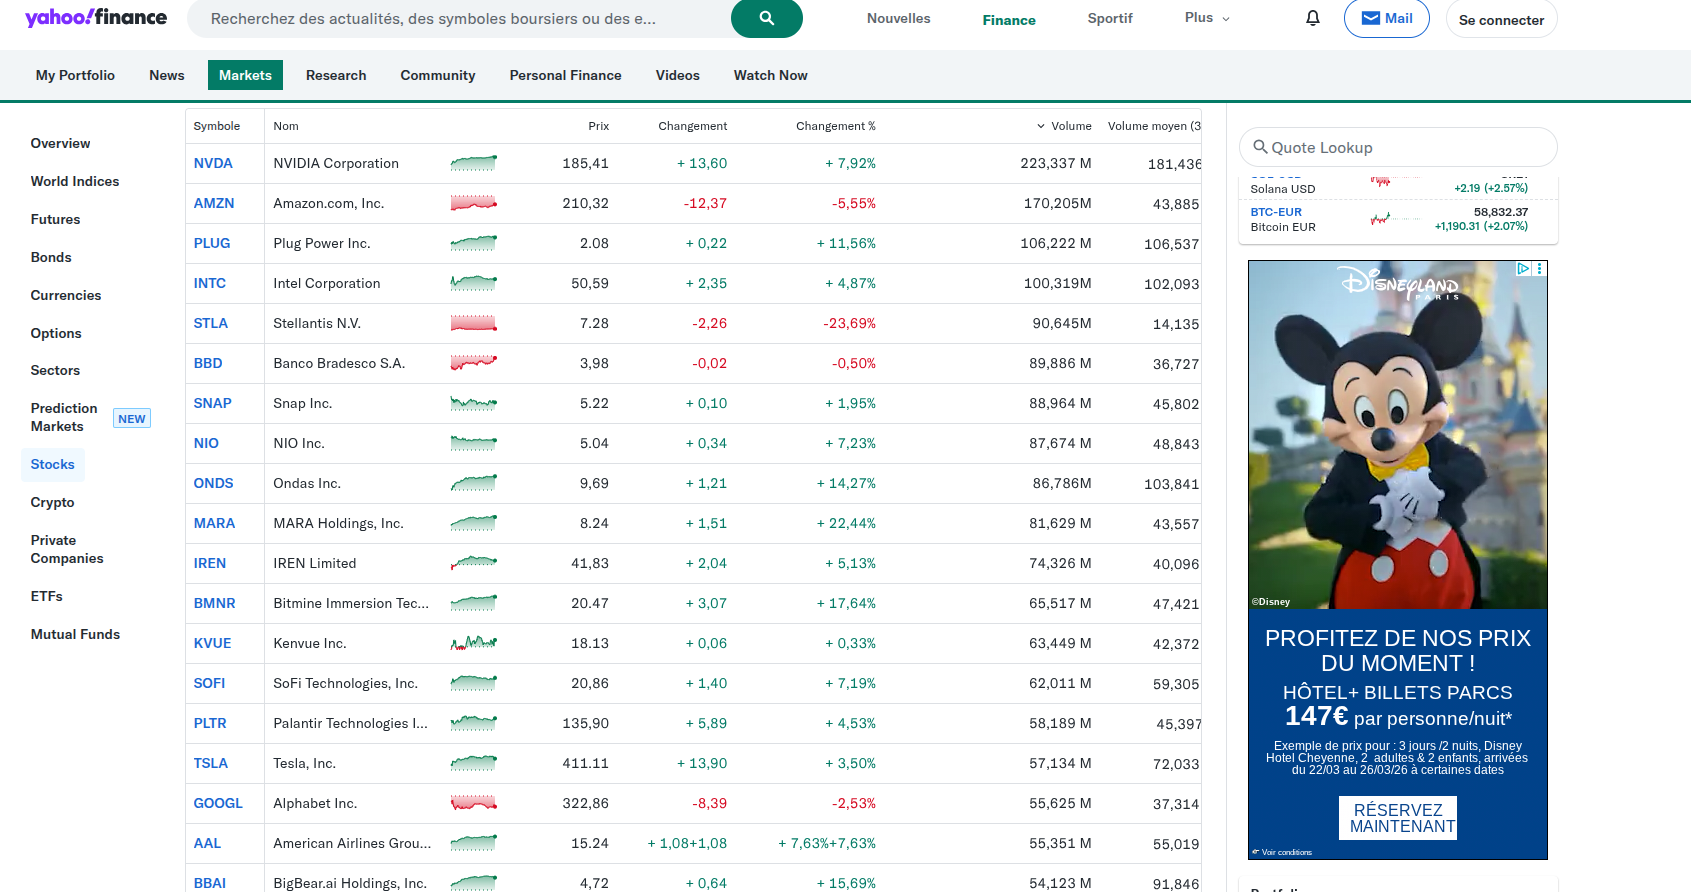

In [6]:
url = 'https://finance.yahoo.com/most-active?offset={offset_val}&count=100'

In [7]:
headers = {
    'User-Agent': 'Nadya DeBeers',
    'From': 'nadya.debeers@hotmail.com'
}
offset_val = 0
response = requests.get(url, headers=headers)

In [8]:
response.status_code

200

Un code d'état (status_code) compris entre 200 et 300 signifie que notre URL a été téléchargée avec succès et qu'elle est prête à être lue.

In [9]:
url_contents = response.text

Jetons un coup d'œil aux 1000 premiers caractères de notre URL.

In [10]:
url_contents[:1000]

'<!doctype html>\n<html lang="en-US" theme="auto" data-color-theme-enabled="true" data-color-scheme="auto" class="desktop neo-green dock-upscale">\n    <head>\n        <meta charset="utf-8" />\n        <meta name="oath:guce:consent-host" content="guce.yahoo.com" />\n        <link rel="preconnect" href="//s.yimg.com" crossorigin="anonymous"><link rel="preconnect" href="//geo.yahoo.com"/><link rel="preconnect" href="//query1.finance.yahoo.com"/><link rel="preconnect" href="//consent.cmp.oath.com"/><link rel="preload" href="/__rapidworker-1.2.js" as="worker"/><link rel="preconnect" href="https://s.yimg.com/uc/finance/webcore/js/_staticFinProtobuf.adb9bf9ae7922cf2dccf.js"/><link rel="preconnect" href="https://cdn.jsdelivr.net/npm/protobufjs@7.1.2/dist/minimal/protobuf.min.js"/><script>window.finNeoPageStart = Date.now();</script><script>\n    (function(){if(!window.YAHOO){window.YAHOO={}};window.YAHOO.context={"consent":{"allowContentPersonalization":true,"allowCrossDeviceMapping":true,"al

Nous allons maintenant enregistrer notre URL sous la forme d'un fichier HTML.

In [12]:
with open('yahoo-finance-most-active.html', 'w', encoding="utf-8") as file:
    file.write(url_contents)

Nous pouvons créer une fonction capable de télécharger n'importe quelle URL sous forme de fichier HTML, afin de pouvoir en extraire les informations par la suite.

In [13]:
def download_web_page(url):
    headers = {
    'User-Agent': 'Nadya DeBeers',
    'From': 'nadya.debeers@hotmail.com'
}
    response = requests.get(url, headers=headers)
    status_code = response.status_code
    if status_code in range(200,300):
        url_contents = response.text
        with open('new-downloaded-web-page.html', 'w', encoding="utf-8") as file:
            file.write(url_contents)
        print('Status code is within an okay range of {}.'.format(status_code))

    else:
        return

Nous pouvons utiliser notre fonction pour télécharger un autre article de Yahoo! Finance concernant les cryptomonnaies

In [14]:
download_web_page('https://finance.yahoo.com/cryptocurrencies/')

Status code is within an okay range of 200.


### 2. Création d'un document BeautifulSoup pour l'analyse

We'll download the BeautifulSoup library so we Nous allons télécharger la bibliothèque BeautifulSoup afin de pouvoir analyser (parser) les articles.

In [15]:
!pip install beautifulsoup4 --upgrade --quiet
from bs4 import BeautifulSoup

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 4.9 MB/s eta 0:00:00


In [16]:
with open('yahoo-finance-most-active.html', 'r') as f:
    html_source = f.read()

In [17]:
len(html_source)

2526784

In [18]:
with open('yahoo-finance-most-active.html', 'r') as f:
    html_source = f.read()
doc = BeautifulSoup(html_source, 'html.parser')

Nous pouvons extraire le titre de l'article.

In [19]:
title = doc.title

In [20]:
title.text

'Most Active Stocks: US stocks with the highest trading volume today - Yahoo Finance'

### 3. Analyse (Parsing) du document BeautifulSoup

Nous allons maintenant identifier les balises (tags) et les classes qui contiennent les informations qui nous intéressent.

Comme vous pouvez le voir sur l'image ci-dessous, les informations boursières se trouvent à l'intérieur de la balise```tr_tag```. La classe varie légèrement car les lignes ont des couleurs différentes (alternance de couleurs). Nous pouvons utiliser un sous-ensemble de la classe, ```class_='simpTblRow'``` , qui est commun aux deux types de lignes.

![](https://i.imgur.com/8FvOL33.png)

In [21]:
with open('yahoo-finance-most-active.html', 'r', encoding='utf-8') as f:
    html_source = f.read()

doc = BeautifulSoup(html_source, 'html.parser')

# Try to find the tbody tag first without assuming class, then with specific class
tbody_tag = doc.find('tbody')

if tbody_tag:
    tr_class_tags = tbody_tag.find_all('tr')
    print(f"Found {len(tr_class_tags)} <tr> tags inside <tbody>.")
else:
    # Fallback to the original class name search if a generic tbody is not found
    tbody_tag = doc.find('tbody', class_='react-table-main-group')
    if tbody_tag:
        tr_class_tags = tbody_tag.find_all('tr')
        print(f"Found {len(tr_class_tags)} <tr> tags inside <tbody> with class 'react-table-main-group'.")
    else:
        print("Could not find a <tbody> tag. The website structure might have changed significantly.")
        tr_class_tags = []

tr_class_tags[:2]

Found 100 <tr> tags inside <tbody>.


[<tr class="row yf-1uayyp1" data-testid="data-table-v2-row" data-testid-row="0"> <td class="[&amp;_.symbol]:tw-text-md yf-1uayyp1 lpin shad" data-testid-cell="ticker" style="--_depth: false;"> <div style="display: contents; --background-color:transparent; --hover-bg-color:transparent; --hover-color:var(--enabled-active-emph); --text-color:var(--enabled-active-emph); --hover-focus-color:var(--hovered-emph-same); --text-decoration:underline;"><span class="ticker-wrapper yf-1pdfbgz"><a aria-label="NVIDIA Corporation" class="ticker medium [&amp;_.symbol]:tw-text-md hover noPadding yf-1pdfbgz" data-testid="table-cell-ticker" data-ylk="elm:qte;elmt:link;itc:0;sec:stocks-datatable;slk:NVDA" href="/quote/NVDA/" title="NVIDIA Corporation"> <div class="name yf-1pdfbgz"> <span class="symbol yf-1pdfbgz">NVDA </span> </div> </a> </span></div> </td> <td class="leftAlignHeader companyName yf-1uayyp1" data-testid-cell="companyshortname.raw" style="--_depth: false;"> <div class="leftAlignHeader company

Nous pouvons effectuer une vérification pour nous assurer qu'il y a bien 100 balises <tr>, ce qui correspond à ce que nous attendons puisque l'article présente le top 100 des actions.

In [22]:
tr_tag_amount = len(tr_class_tags)
if tr_tag_amount == 100:
    print("We have the correct amount of tr tags.")

We have the correct amount of tr tags.


ous pouvons maintenant examiner la première balise ```tr_tag``` qui contient les informations relatives à l'action OXY (Occidental Petroleum Corporation)

In [23]:
tr_class_tag1 = tr_class_tags[0]
tr_class_tag1

<tr class="row yf-1uayyp1" data-testid="data-table-v2-row" data-testid-row="0"> <td class="[&amp;_.symbol]:tw-text-md yf-1uayyp1 lpin shad" data-testid-cell="ticker" style="--_depth: false;"> <div style="display: contents; --background-color:transparent; --hover-bg-color:transparent; --hover-color:var(--enabled-active-emph); --text-color:var(--enabled-active-emph); --hover-focus-color:var(--hovered-emph-same); --text-decoration:underline;"><span class="ticker-wrapper yf-1pdfbgz"><a aria-label="NVIDIA Corporation" class="ticker medium [&amp;_.symbol]:tw-text-md hover noPadding yf-1pdfbgz" data-testid="table-cell-ticker" data-ylk="elm:qte;elmt:link;itc:0;sec:stocks-datatable;slk:NVDA" href="/quote/NVDA/" title="NVIDIA Corporation"> <div class="name yf-1pdfbgz"> <span class="symbol yf-1pdfbgz">NVDA </span> </div> </a> </span></div> </td> <td class="leftAlignHeader companyName yf-1uayyp1" data-testid-cell="companyshortname.raw" style="--_depth: false;"> <div class="leftAlignHeader companyN

Si nous examinons la première balise ```tr_tag``` dans l'image ci-dessous, nous pouvons voir que chaque élément de l'action est contenu dans une balise ```td_tag```. Nous allons extraire ces balises à l'étape suivante.

Une fois les balises ```td_tag``` extraites, nous pourrons ensuite extraire la balise ```a_tag``` , qui contient le ticker de l'action (OXY).

Un ticker (ou symbole boursier) est l'acronyme qui représente une action sur le marché.

![](https://i.imgur.com/wpmGEYY.png)

In [24]:
td_tag = tr_class_tag1.find_all('td')
td_tag

[<td class="[&amp;_.symbol]:tw-text-md yf-1uayyp1 lpin shad" data-testid-cell="ticker" style="--_depth: false;"> <div style="display: contents; --background-color:transparent; --hover-bg-color:transparent; --hover-color:var(--enabled-active-emph); --text-color:var(--enabled-active-emph); --hover-focus-color:var(--hovered-emph-same); --text-decoration:underline;"><span class="ticker-wrapper yf-1pdfbgz"><a aria-label="NVIDIA Corporation" class="ticker medium [&amp;_.symbol]:tw-text-md hover noPadding yf-1pdfbgz" data-testid="table-cell-ticker" data-ylk="elm:qte;elmt:link;itc:0;sec:stocks-datatable;slk:NVDA" href="/quote/NVDA/" title="NVIDIA Corporation"> <div class="name yf-1pdfbgz"> <span class="symbol yf-1pdfbgz">NVDA </span> </div> </a> </span></div> </td>,
 <td class="leftAlignHeader companyName yf-1uayyp1" data-testid-cell="companyshortname.raw" style="--_depth: false;"> <div class="leftAlignHeader companyName yf-362rys enableMaxWidth" title="NVIDIA Corporation">NVIDIA Corporation <

In [25]:
# This cell is no longer needed as the a_tag extraction is now directly handled within parse_stocks and similar functions. However, to avoid an error if executed in isolation, we can leave it with an empty list.
a_tag = []
# a_tag = td_tag[0].find_all('a', recursive=False) # Original problematic line
a_tag

[]

Nous allons maintenant extraire chacun des éléments de la première action.

In [26]:
ticker_name = td_tag[0].find('a', attrs={'data-testid': 'table-cell-ticker'}).text.strip()
ticker_name

'NVDA'

In [27]:
name_tag = td_tag[1].text
name_tag

' NVIDIA Corporation  '

In [32]:
price_tag = td_tag[2].text
price_tag

'    '

In [29]:
daily_change_tag = td_tag[3].text
daily_change_tag

'  185.41  +13.60 (+7.92%) '

In [30]:
daily_percentage_change_tag = td_tag[4].text
daily_percentage_change_tag

' +13.60  '

In [36]:
volume_tag = td_tag[5].text
volume_tag

' +7.92%  '

In [37]:
avg_volume_tag = td_tag[6].text
avg_volume_tag

' 223.337M  '

In [38]:
market_cap_tag = td_tag[7].text
market_cap_tag

'      181.436M '

In [39]:
pe_ratio_tag = td_tag[8].text
pe_ratio_tag

' 4.514T  '

Étant donné que le volume, la capitalisation boursière et les ratios PE sont parfois représentés avec les lettres M, k et B (pour million, millier et milliard), nous pouvons créer une fonction qui convertit ces valeurs en nombres entiers afin de pouvoir les comparer plus facilement.

In [40]:
def parse_volume_market_tag(tag):
    volume_str = tag.strip()
    if volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'k':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    elif volume_str[-1] == 'T':
        return int(float(volume_str[:-1]) * 1000000000000)
    else:
        return int(volume_str.replace(',', ''))

In [41]:
parse_volume_market_tag('5k')

5000

In [42]:
parse_volume_market_tag('200.3M')

200300000

In [43]:
parse_volume_market_tag('200')

200

In [44]:
parse_volume_market_tag('200.4B')

200400000000

In [45]:
parse_volume_market_tag('200,500')

200500

### 4. Création de fonctions pour l'affichage des informations

Nous allons maintenant créer une fonction capable d'analyser une balise ```tr_tag``` afin de générer un dictionnaire correspondant contenant toutes les informations relatives à l'action.

In [46]:
def parse_volume_market_tag(tag):
    volume_str = tag.strip()
    if not volume_str or volume_str == 'N/A' or volume_str == '-':
        return 0
    if volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'k':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    elif volume_str[-1] == 'T':
        return int(float(volume_str[:-1]) * 1000000000000)
    else:
        return int(volume_str.replace(',', ''))

def parse_stocks(tr_class_tag):
    td_tag = tr_class_tag.find_all('td')

    # Stock ticker: data-testid-cell="ticker" -> td_tag[0] -> a tag -> text
    ticker_name = td_tag[0].find('a', attrs={'data-testid': 'table-cell-ticker'}).text.strip()

    # Stock name: data-testid-cell="companyshortname.raw" -> td_tag[1] -> div tag -> title attribute or text
    name_tag_div = td_tag[1].find('div', class_='companyName') # Look for the div with class companyName
    name_tag = name_tag_div.get('title', name_tag_div.text).strip().replace(",", "") if name_tag_div else ''

    # Last price of stock: data-testid-cell="intradayprice" -> td_tag[3] -> span with data-testid="change" -> text
    price_span = td_tag[3].find('span', attrs={'data-testid': 'change'})
    price_tag = float(price_span.text.replace(',', '')) if price_span and price_span.text.strip() != '-' else 0.0

    # Stock change: data-testid-cell="intradaypricechange" -> td_tag[4] -> span with data-testid="colorChange" -> text
    daily_change_span = td_tag[4].find('span', attrs={'data-testid': 'colorChange'})
    daily_change_tag = daily_change_span.text.strip() if daily_change_span else ''

    # Percentage change: data-testid-cell="percentchange" -> td_tag[5] -> span with data-testid="colorChange" -> text
    daily_percentage_change_span = td_tag[5].find('span', attrs={'data-testid': 'colorChange'})
    daily_percentage_change_tag = daily_percentage_change_span.text.strip() if daily_percentage_change_span else ''

    # Volume: data-testid-cell="dayvolume" -> td_tag[6] -> span with data-testid="change" -> text
    volume_span = td_tag[6].find('span', attrs={'data-testid': 'change'})
    volume_tag = parse_volume_market_tag(volume_span.text) if volume_span else 0

    # Avg volume: data-testid-cell="avgdailyvol3m" -> td_tag[7] -> text
    avg_volume_tag = parse_volume_market_tag(td_tag[7].text) if td_tag[7].text.strip() else 0

    # Market cap: data-testid-cell="intradaymarketcap" -> td_tag[8] -> span with data-testid="change" -> text
    market_cap_span = td_tag[8].find('span', attrs={'data-testid': 'change'})
    market_cap_tag = parse_volume_market_tag(market_cap_span.text) if market_cap_span else 0

    # PE ratio: data-testid-cell="peratio.lasttwelvemonths" -> td_tag[9] -> text
    pe_ratio_tag = td_tag[9].text.strip() if td_tag[9].text.strip() else 'N/A'
    # Handle cases where PE ratio might be a hyphen or N/A
    try:
        pe_ratio_tag = float(pe_ratio_tag)
    except ValueError:
        pe_ratio_tag = 'N/A'

    # Return a dictionary
    return {
        'Stock ticker': ticker_name,
        'Stock name': name_tag,
        'Last price of stock': price_tag,
        'Stock change': daily_change_tag,
        'Stock percentage change' : daily_percentage_change_tag,
        'Volume' : volume_tag,
        'Average volume over 3 months' : avg_volume_tag,
        'Market cap' : market_cap_tag,
        'PE ratio' : pe_ratio_tag
    }

In [47]:
parse_stocks(tr_class_tags[0])

{'Stock ticker': 'NVDA',
 'Stock name': 'NVIDIA Corporation',
 'Last price of stock': 185.41,
 'Stock change': '+13.60',
 'Stock percentage change': '+7.92%',
 'Volume': 223337000,
 'Average volume over 3 months': 181436000,
 'Market cap': 4514000000000,
 'PE ratio': 42.54}

In [48]:
parse_stocks(tr_class_tags[4])

{'Stock ticker': 'STLA',
 'Stock name': 'Stellantis N.V.',
 'Last price of stock': 7.28,
 'Stock change': '-2.26',
 'Stock percentage change': '-23.69%',
 'Volume': 90645000,
 'Average volume over 3 months': 14135000,
 'Market cap': 21030000000,
 'PE ratio': 'N/A'}

Nous pouvons également créer une fonction pour lister l'ensemble des tickers (symboles boursiers) présents dans l'article.

In [49]:
def list_tickers(tr_class_tag):
    td_tag = tr_class_tag.find_all('td')
    # Stock ticker: data-testid-cell="ticker" -> td_tag[0] -> a tag with data-testid="table-cell-ticker" -> text
    ticker_name = td_tag[0].find('a', attrs={'data-testid': 'table-cell-ticker'}).text.strip()
    return ticker_name

In [50]:
list_tickers(tr_class_tags[4])

'STLA'

In [51]:
stock_tickers = [list_tickers(x) for x in tr_class_tags]
stock_tickers[:5]

['NVDA', 'AMZN', 'PLUG', 'INTC', 'STLA']

Nous allons maintenant créer une fonction qui utilise la compréhension de liste (list comprehension) afin d'analyser les informations boursières de toutes nos actions en une seule fois.

In [52]:
most_active_stocks = [parse_stocks(x) for x in tr_class_tags]
most_active_stocks[:5]

[{'Stock ticker': 'NVDA',
  'Stock name': 'NVIDIA Corporation',
  'Last price of stock': 185.41,
  'Stock change': '+13.60',
  'Stock percentage change': '+7.92%',
  'Volume': 223337000,
  'Average volume over 3 months': 181436000,
  'Market cap': 4514000000000,
  'PE ratio': 42.54},
 {'Stock ticker': 'AMZN',
  'Stock name': 'Amazon.com Inc.',
  'Last price of stock': 210.32,
  'Stock change': '-12.37',
  'Stock percentage change': '-5.55%',
  'Volume': 170205000,
  'Average volume over 3 months': 43885000,
  'Market cap': 2258000000000,
  'PE ratio': 31.06},
 {'Stock ticker': 'PLUG',
  'Stock name': 'Plug Power Inc.',
  'Last price of stock': 2.08,
  'Stock change': '+0.22',
  'Stock percentage change': '+11.56%',
  'Volume': 106222000,
  'Average volume over 3 months': 106537000,
  'Market cap': 2888000000,
  'PE ratio': 'N/A'},
 {'Stock ticker': 'INTC',
  'Stock name': 'Intel Corporation',
  'Last price of stock': 50.59,
  'Stock change': '+2.35',
  'Stock percentage change': '+4.87

Nous pouvons regrouper toutes nos fonctions pour obtenir le top 5 des actions les plus actives, du rang 101 à 197, à partir d'une [autre URL](https://finance.yahoo.com/most-active?count=100&offset=100).

In [53]:
def parse_stock_pages(offset_val):

    url2 ='https://finance.yahoo.com/most-active?offset={}&count=100'.format(offset_val)

    response2 = requests.get(url2, headers=headers)

    download_web_page(url2)

    with open('new-downloaded-web-page.html', 'r') as f:
        html_source3 = f.read()

    doc3 = BeautifulSoup(html_source3, 'html.parser')

    tr_class_tags3 = doc3.find_all('tr',class_='simpTblRow')

    most_active_stocks_100_200 = [parse_stocks(x) for x in tr_class_tags3]
    return most_active_stocks_100_200

In [54]:
most_active_5_stocks_next_page = parse_stock_pages(100)[:5]
most_active_5_stocks_next_page

Status code is within an okay range of 200.


[]

In [55]:
most_active_stocks_100_200 = parse_stock_pages(100)

Status code is within an okay range of 200.


### 5. Création d'un fichier CSV à partir des informations analysées

Nous pouvons écrire une fonction qui crée un fichier CSV à partir de nos informations analysées.

In [56]:
def write_csv(items, path):
    with open(path, 'w') as f:
        if len(items) == 0:
            return

        headers = list(items[0].keys())
        f.write(','.join(headers) + '\n')

        for item in items:
            values = []
            for header in headers:
                values.append(str(item.get(header, "")))
            f.write(','.join(values) + "\n")

In [57]:
write_csv(most_active_stocks, 'most-active-stocks.csv')

In [58]:
write_csv(most_active_stocks_100_200, 'most-active-stocks-next-page.csv')

In [59]:
with open('most-active-stocks.csv', 'r') as f:
    print(f.read())

Stock ticker,Stock name,Last price of stock,Stock change,Stock percentage change,Volume,Average volume over 3 months,Market cap,PE ratio
NVDA,NVIDIA Corporation,185.41,+13.60,+7.92%,223337000,181436000,4514000000000,42.54
AMZN,Amazon.com Inc.,210.32,-12.37,-5.55%,170205000,43885000,2258000000000,31.06
PLUG,Plug Power Inc.,2.08,+0.22,+11.56%,106222000,106537000,2888000000,N/A
INTC,Intel Corporation,50.59,+2.35,+4.87%,100319000,102093000,252706000000,N/A
STLA,Stellantis N.V.,7.28,-2.26,-23.69%,90645000,14135000,21030000000,N/A
BBD,Banco Bradesco S.A.,3.98,-0.02,-0.50%,89886000,36727000,42291000000,10.77
SNAP,Snap Inc.,5.22,+0.10,+1.95%,88964000,45802000,8816000000,N/A
NIO,NIO Inc.,5.04,+0.34,+7.23%,87674000,48843000,12744000000,N/A
ONDS,Ondas Inc.,9.69,+1.21,+14.27%,86786000,103841000,4110000000,N/A
MARA,MARA Holdings Inc.,8.24,+1.51,+22.44%,81629000,43557000,3116000000,3.17
IREN,IREN Limited,41.83,+2.04,+5.13%,74326000,40096000,13877000000,33.22
BMNR,Bitmine Immersion Technologies Inc.,

In [60]:
with open('most-active-stocks-next-page.csv', 'r') as f:
    print(f.read())

### 6. Affichage des fichiers CSV dans des DataFrames Pandas

In [61]:
import pandas as pd

In [63]:
most_active_df = pd.read_csv('most-active-stocks.csv')
most_active_df

,Stock ticker,Stock name,Last price of stock,Stock change,Stock percentage change,Volume,Average volume over 3 months,Market cap,PE ratio
0,NVDA,NVIDIA Corporation,185.41,13.60,+7.92%,223337000,181436000,4514000000000,42.54
1,AMZN,Amazon.com Inc.,210.32,-12.37,-5.55%,170205000,43885000,2258000000000,31.06
2,PLUG,Plug Power Inc.,2.08,0.22,+11.56%,106222000,106537000,2888000000,NaN
3,INTC,Intel Corporation,50.59,2.35,+4.87%,100319000,102093000,252706000000,NaN
4,STLA,Stellantis N.V.,7.28,-2.26,-23.69%,90645000,14135000,21030000000,NaN
...,...,...,...,...,...,...,...,...,...
95,RDDT,Reddit Inc.,139.83,-11.22,-7.43%,20881000,4737000,26713000000,NaN
96,WMT,Walmart Inc.,131.18,4.24,+3.34%,20798000,29809000,1046000000000,38.96
97,CCC,CCC Intelligent Solutions Holdings Inc.,5.78,0.10,+1.76%,20229000,9195000,3764000000,NaN
98,SNDK,Sandisk Corporation,597.95,21.75,+3.77%,20212000,15211000,88238000000,NaN


Nous allons maintenant examiner plusieurs DataFrames différents, triés selon diverses valeurs.

In [64]:
order_by_mark_cap_df = most_active_df.sort_values('Market cap', ascending=False)
order_by_mark_cap_df

,Stock ticker,Stock name,Last price of stock,Stock change,Stock percentage change,Volume,Average volume over 3 months,Market cap,PE ratio
0,NVDA,NVIDIA Corporation,185.41,13.60,+7.92%,223337000,181436000,4514000000000,42.54
21,AAPL,Apple Inc.,278.12,2.21,+0.80%,50051000,48062000,4088000000000,34.99
61,GOOG,Alphabet Inc.,323.10,-8.23,-2.48%,29942000,23917000,3909000000000,30.67
16,GOOGL,Alphabet Inc.,322.86,-8.39,-2.53%,55625000,37314000,3906000000000,30.67
27,MSFT,Microsoft Corporation,401.14,7.47,+1.90%,45884000,29683000,2981000000000,24.63
...,...,...,...,...,...,...,...,...,...
36,COTY,Coty Inc.,2.66,-0.49,-15.56%,40171000,7433000,2341000000,NaN
90,JBLU,JetBlue Airways Corporation,6.36,0.32,+5.30%,23047000,18858000,2313000000,NaN
18,BBAI,BigBear.ai Holdings Inc.,4.72,0.64,+15.69%,54123000,91846000,2161000000,NaN
82,RXRX,Recursion Pharmaceuticals Inc.,3.98,0.42,+11.80%,24863000,23217000,2075000000,NaN


In [65]:
order_by_pe_ratio_df = most_active_df.sort_values('PE ratio', ascending=False)
order_by_pe_ratio_df

,Stock ticker,Stock name,Last price of stock,Stock change,Stock percentage change,Volume,Average volume over 3 months,Market cap,PE ratio
15,TSLA,Tesla Inc.,411.11,13.90,+3.50%,57134000,72033000,1543000000000,367.79
26,GRAB,Grab Holdings Limited,4.27,0.12,+2.89%,47170000,49036000,17451000000,206.57
14,PLTR,Palantir Technologies Inc.,135.90,5.89,+4.53%,58189000,45397000,323909000000,206.37
55,WBD,Warner Bros. Discovery Inc.,27.36,0.60,+2.24%,31225000,42002000,67839000000,137.85
44,OWL,Blue Owl Capital Inc.,12.52,0.89,+7.65%,34503000,16300000,19571000000,101.70
...,...,...,...,...,...,...,...,...,...
94,ROIV,Roivant Sciences Ltd.,25.82,4.68,+22.14%,21526000,7198000,18479000000,NaN
95,RDDT,Reddit Inc.,139.83,-11.22,-7.43%,20881000,4737000,26713000000,NaN
97,CCC,CCC Intelligent Solutions Holdings Inc.,5.78,0.10,+1.76%,20229000,9195000,3764000000,NaN
98,SNDK,Sandisk Corporation,597.95,21.75,+3.77%,20212000,15211000,88238000000,NaN


In [66]:
order_by_vol_df = most_active_df.sort_values('Volume', ascending=False)
order_by_vol_df

,Stock ticker,Stock name,Last price of stock,Stock change,Stock percentage change,Volume,Average volume over 3 months,Market cap,PE ratio
0,NVDA,NVIDIA Corporation,185.41,13.60,+7.92%,223337000,181436000,4514000000000,42.54
1,AMZN,Amazon.com Inc.,210.32,-12.37,-5.55%,170205000,43885000,2258000000000,31.06
2,PLUG,Plug Power Inc.,2.08,0.22,+11.56%,106222000,106537000,2888000000,NaN
3,INTC,Intel Corporation,50.59,2.35,+4.87%,100319000,102093000,252706000000,NaN
4,STLA,Stellantis N.V.,7.28,-2.26,-23.69%,90645000,14135000,21030000000,NaN
...,...,...,...,...,...,...,...,...,...
95,RDDT,Reddit Inc.,139.83,-11.22,-7.43%,20881000,4737000,26713000000,NaN
96,WMT,Walmart Inc.,131.18,4.24,+3.34%,20798000,29809000,1046000000000,38.96
97,CCC,CCC Intelligent Solutions Holdings Inc.,5.78,0.10,+1.76%,20229000,9195000,3764000000,NaN
98,SNDK,Sandisk Corporation,597.95,21.75,+3.77%,20212000,15211000,88238000000,NaN


In [67]:
order_by_price_df = most_active_df.sort_values('Last price of stock')
order_by_price_df

,Stock ticker,Stock name,Last price of stock,Stock change,Stock percentage change,Volume,Average volume over 3 months,Market cap,PE ratio
2,PLUG,Plug Power Inc.,2.08,0.22,+11.56%,106222000,106537000,2888000000,NaN
36,COTY,Coty Inc.,2.66,-0.49,-15.56%,40171000,7433000,2341000000,NaN
74,ABEV,Ambev S.A.,2.94,0.03,+1.03%,27234000,29750000,46165000000,15.17
32,DNN,Denison Mines Corp.,3.69,0.23,+6.65%,42011000,50393000,3311000000,NaN
82,RXRX,Recursion Pharmaceuticals Inc.,3.98,0.42,+11.80%,24863000,23217000,2075000000,NaN
...,...,...,...,...,...,...,...,...,...
51,AVGO,Broadcom Inc.,332.92,22.41,+7.22%,31949000,31114000,1578000000000,65.10
47,MU,Micron Technology Inc.,394.69,11.80,+3.08%,33394000,31884000,444227000000,36.33
27,MSFT,Microsoft Corporation,401.14,7.47,+1.90%,45884000,29683000,2981000000000,24.63
15,TSLA,Tesla Inc.,411.11,13.90,+3.50%,57134000,72033000,1543000000000,367.79


### 7. Un peu de visualisation de données simple

Afin de visualiser les DataFrames précédents, il peut être utile d'utiliser des graphiques tels que des diagrammes en barres (bar charts). Bien que ces graphiques soient très simples, ils ont pour but de mettre en lumière certains des résultats obtenus à partir de nos articles.

In [70]:
import matplotlib.pyplot as plt

A plot that shows stocks from the 100 most active stocks from highest to lowest PE ratio.

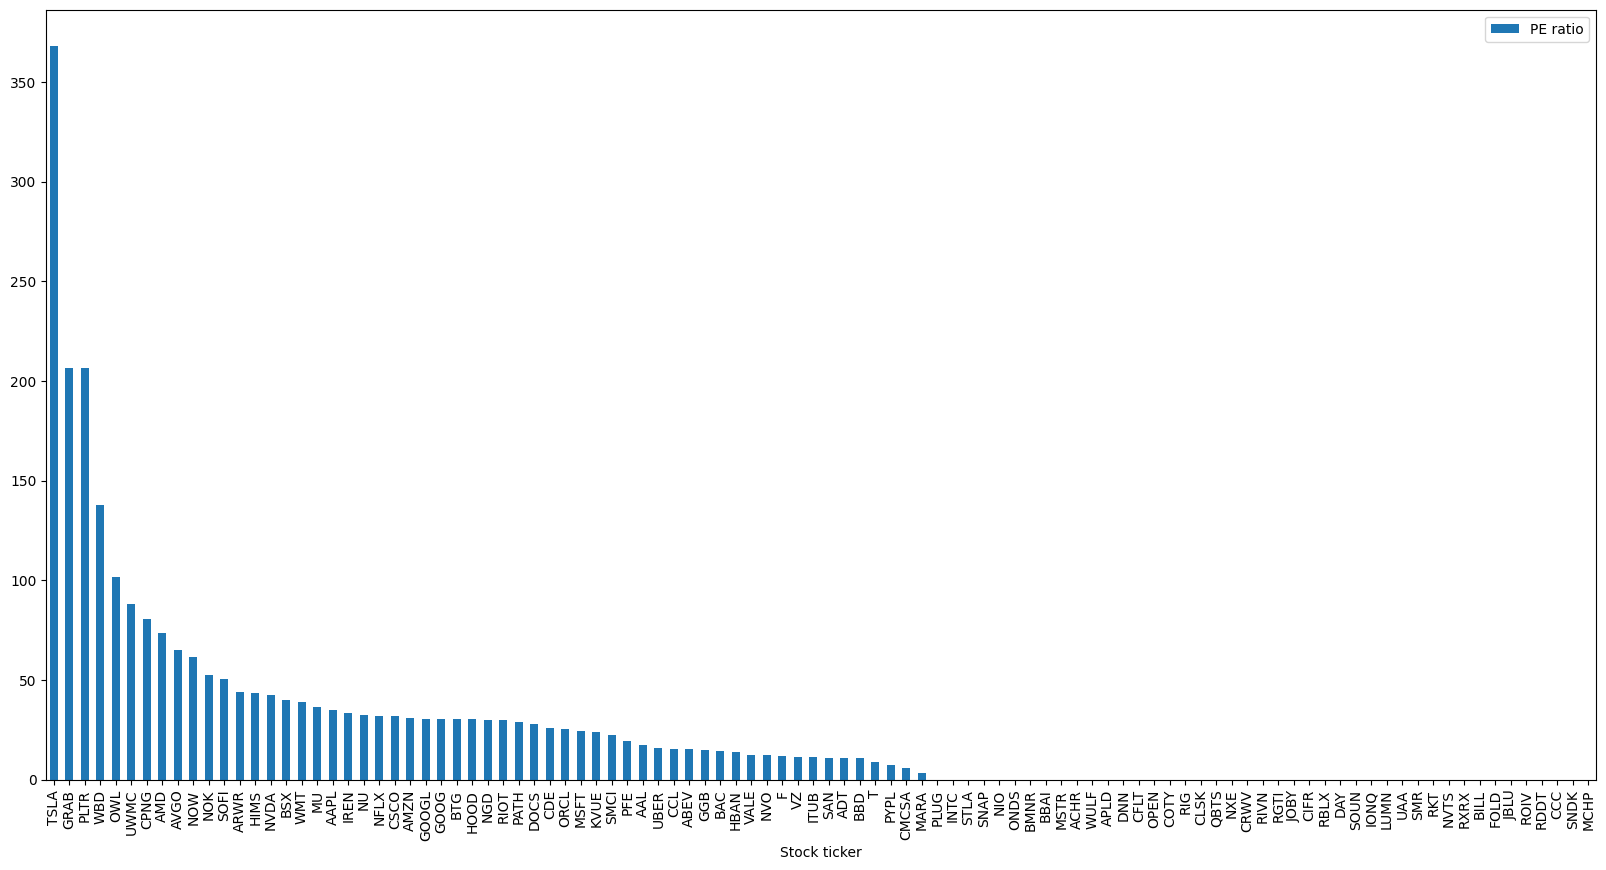

In [71]:
order_by_pe_ratio_df.plot(x ='Stock ticker', y='PE ratio', kind = 'bar',figsize=(20,10))
plt.show()

Un graphique représentant les actions parmi les 100 plus actives, classées du volume le plus élevé au plus bas.

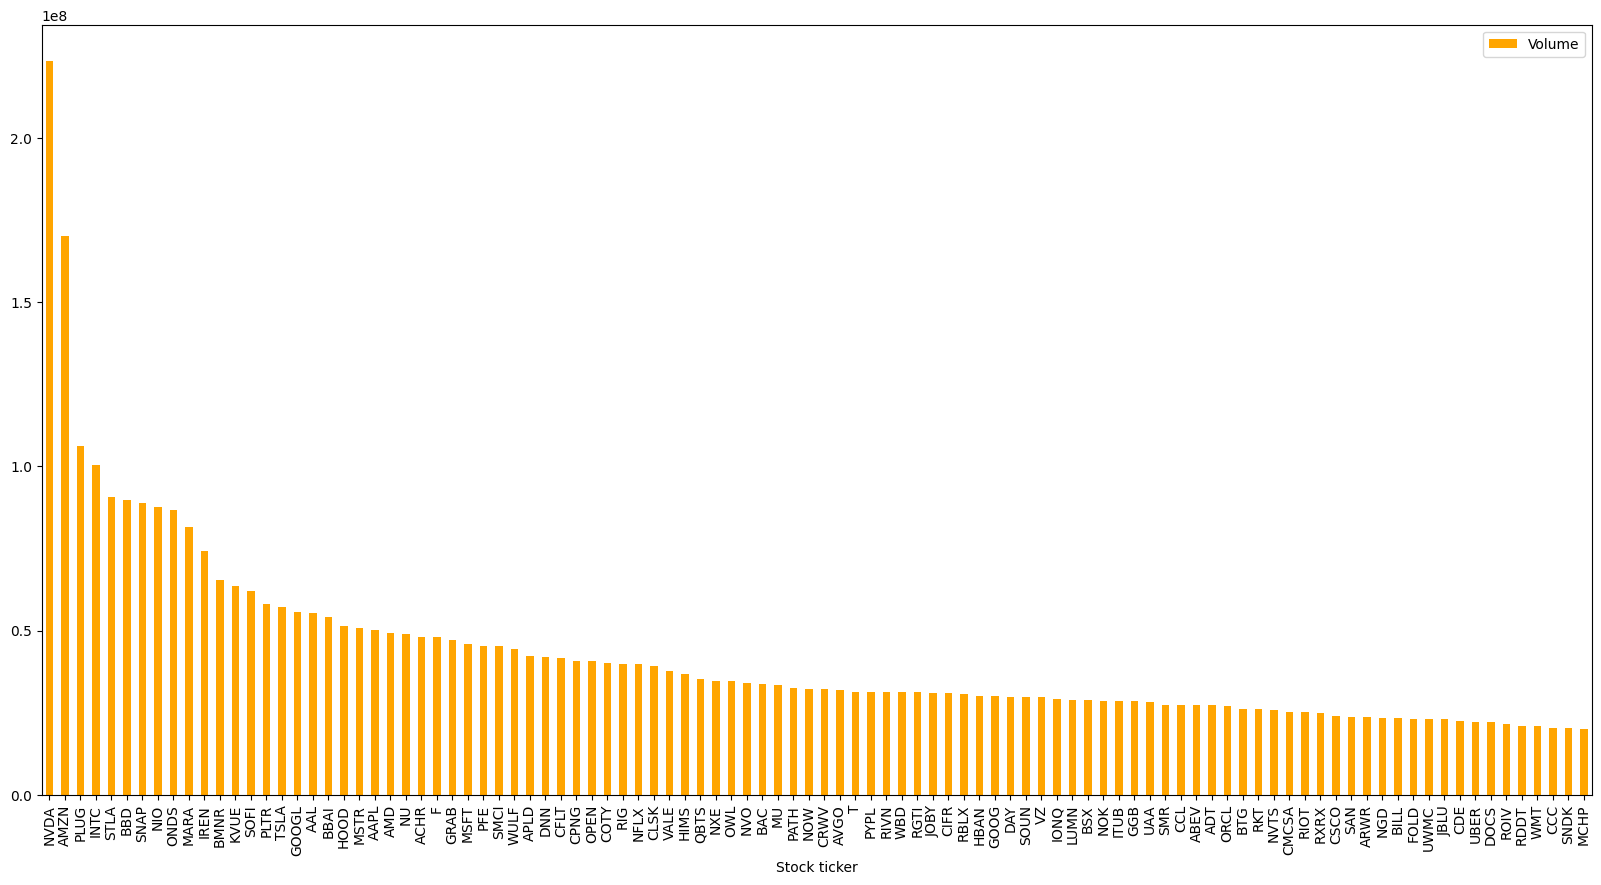

In [72]:
order_by_vol_df.plot(x ='Stock ticker', y='Volume', kind = 'bar',figsize=(20,10),color='orange')
plt.show()

Un graphique représentant les actions parmi les 100 plus actives, classées de la moins chère à la plus chère (par ordre de prix croissant).

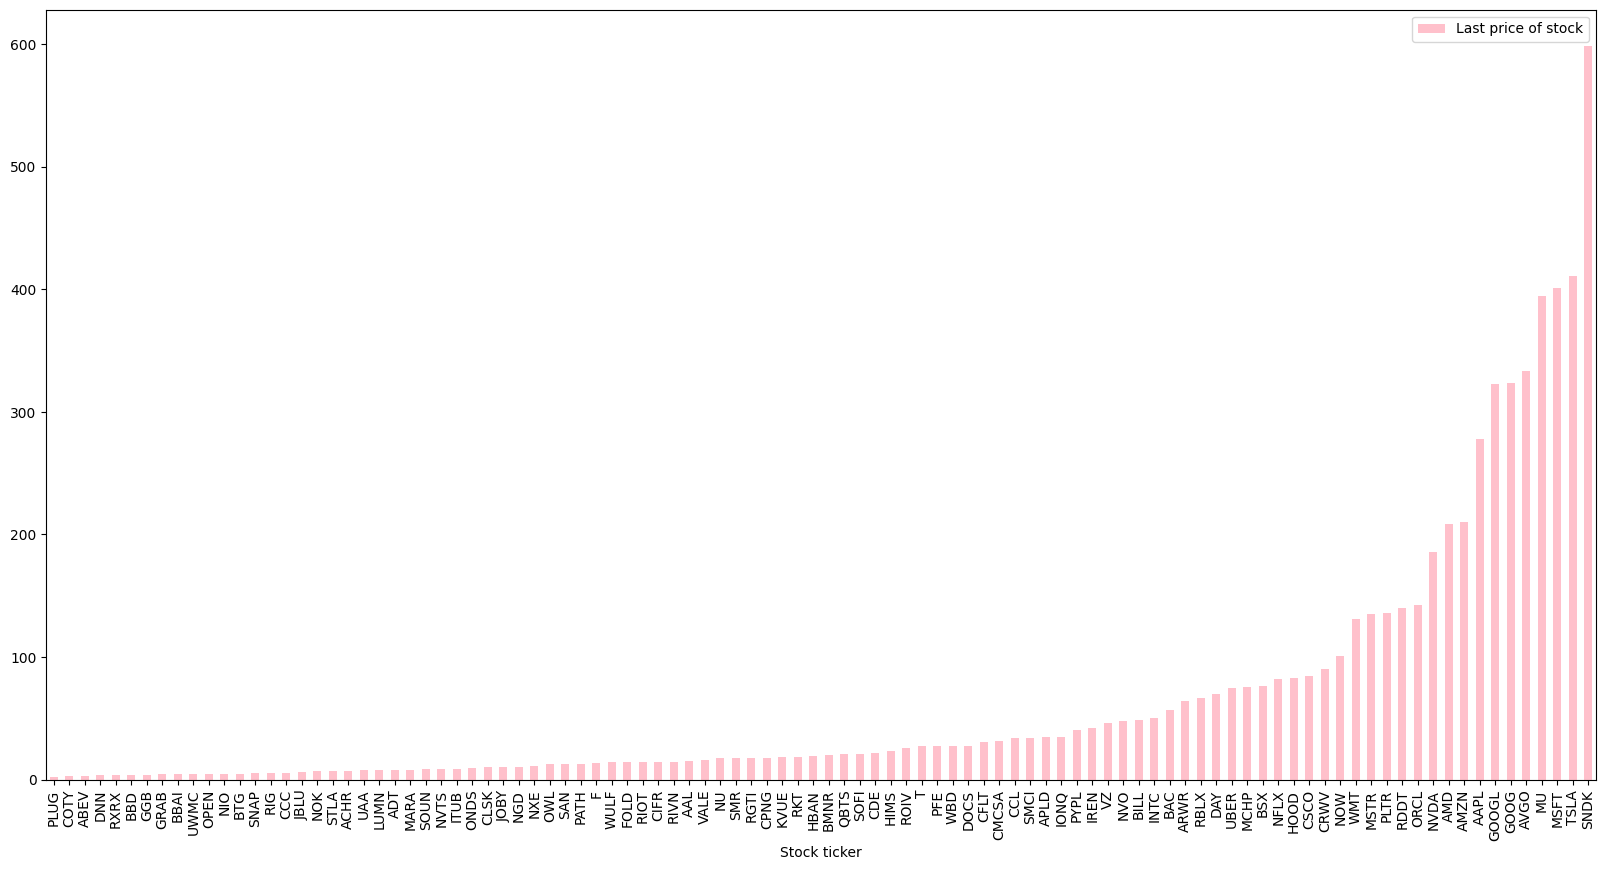

In [73]:
order_by_price_df.plot(x ='Stock ticker', y='Last price of stock', kind = 'bar',figsize=(20,10),color='pink')
plt.show()

### 8. Résumé

En résumé, nous avons téléchargé deux articles, les avons analysés pour en extraire des informations, puis nous avons créé des fonctions afin de générer des dictionnaires à partir de ces données. Nous avons ensuite enregistré ces dictionnaires sous forme de fichiers CSV, converti ces fichiers en DataFrames Pandas et, enfin, visualisé certains de ces DataFrames.

Ce projet est destiné à être informatif et de nature générale ; il ne s'applique en aucun cas à la situation personnelle de quiconque.

### 9. Idées de travaux futurs

À l'avenir, j'aimerais recueillir davantage d'informations sur les actions individuelles, notamment des données historiques, afin de pouvoir établir des comparaisons sur le long terme. Je souhaiterais également approfondir les modes d'affichage des données et en tirer des conclusions utiles à des fins éducatives. Je pense que ce projet peut servir de tremplin vers mon objectif de réduction des inégalités de richesse.

### 10. References

* "Liste et prix des cryptomonnaies, principales cryptomonnaies." Yahoo! Finance, Yahoo!, 8 février 2026, https://finance.yahoo.com/cryptocurrencies/.

* “Actions les plus actives aujourd'hui." Yahoo! Finance, Yahoo!, 8 février 2026, https://finance.yahoo.com/most-active?offset=0&amp;count=100.

In [74]:
!pip install jovian --upgrade --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 3.2 MB/s eta 0:00:00


In [75]:
import jovian

In [84]:
jovian.commit(files=['most-active-stocks-next-page.csv', 'most-active-stocks.csv'])

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.
